# Visualize TSE, R and S for brain data (coarse grained option)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import infotopo
import xgi
import matplotlib.pyplot as plt
import hypernetx as hnx
import time
import json
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.utils import Bunch

In [68]:
# Define functions
# Function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """Compute TSE complexity efficiently."""
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N+1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Function to compute topological information metrics
def obtain_infotopo_metrics(dataset):
    
    dimension_max = 4 #dataset.shape[1]
    dimension_tot = 12 #dataset.shape[1]
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset) # Make sure the datatype is a Bunch object
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    #Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut

# Function for coarse graining with CompleX Group Interactions (XGI) library
def coarse_grain_with_xgi(hypergraph, desired_num_nodes):
    """
    Coarse-grains a weighted hypergraph to a desired number of nodes using the XGI library.

    Parameters:
        hypergraph (dict): Dictionary where keys are hyperedges (tuples of nodes) and values are weights.
        desired_num_nodes (int): Target number of nodes after coarse-graining.

    Returns:
        dict: Coarse-grained hypergraph with grouped nodes and aggregated weights.
    """
    # Create an XGI hypergraph from the input
    xgi_hypergraph = xgi.Hypergraph()
    for edge, weight in hypergraph.items():
        xgi_hypergraph.add_edge(edge, weight=weight)

    # Map nodes to groups (simple clustering based on node IDs for demonstration)
    unique_nodes = list(xgi_hypergraph.nodes)
    node_features = np.array(unique_nodes).reshape(-1, 1)  # 1D features based on node IDs

    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=desired_num_nodes, random_state=0).fit(node_features)
    node_groups = {node: group for node, group in zip(unique_nodes, kmeans.labels_)}

    # Initialize coarse-grained hypergraph
    coarse_hypergraph = defaultdict(float)

    for edge_id in xgi_hypergraph.edges:
        # Get the members of the edge
        edge_members = xgi_hypergraph.edges.members(edge_id)

        # Map nodes in the hyperedge to their groups
        coarse_hyperedge = tuple(sorted(set(node_groups[node] for node in edge_members)))

        # Aggregate the weight for the coarse-grained hyperedge
        weight = xgi_hypergraph.edges[edge_id].get('weight', 1.0)
        coarse_hypergraph[coarse_hyperedge] += abs(weight)

    return dict(coarse_hypergraph)

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values(df_input):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    window_start = 0
    window_end = window_start + 100

    while window_end < 120: #len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut = obtain_infotopo_metrics(bunch_data.data)
        #Ninfomut = coarse_grain_with_xgi(Ninfomut, 4)
        S_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value < 0)
        R_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value > 0)
        TSE_value = compute_tse_complexity(Ninfomut)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += 10
        window_end += 10

    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    df_output.iloc[:, 1] = df_output.iloc[:, 1] * -1

    max_R = df_output.iloc[:, 0].max()
    max_S = df_output.iloc[:, 1].max()

    if max_S > 0:
        df_output.iloc[:, 1] = df_output.iloc[:, 1] / max_S        
    if max_R > 0:
        df_output.iloc[:, 0] = df_output.iloc[:, 0] / max_R

    return df_output

# Convert a given pandas dataframe to a Bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

In [69]:
# Import data
df = pd.read_csv("C:\\Users\\cyril\\Documents\\Personal\\Github\\PhD_1\\Data\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt", sep='\t', header=None, usecols=lambda col: col != 'Time')
df = df.transpose()
df = interactions_values(df)

2025-01-20 15:04:07,221 : INFO : PROGRESS: at percent #0
2025-01-20 15:04:07,221 : INFO : PROGRESS: at percent #1
2025-01-20 15:04:07,228 : INFO : PROGRESS: at percent #2
2025-01-20 15:04:07,228 : INFO : PROGRESS: at percent #3
2025-01-20 15:04:07,228 : INFO : PROGRESS: at percent #4
2025-01-20 15:04:07,238 : INFO : PROGRESS: at percent #5
2025-01-20 15:04:07,238 : INFO : PROGRESS: at percent #6
2025-01-20 15:04:07,238 : INFO : PROGRESS: at percent #7
2025-01-20 15:04:07,249 : INFO : PROGRESS: at percent #7
2025-01-20 15:04:07,254 : INFO : PROGRESS: at percent #8
2025-01-20 15:04:07,254 : INFO : PROGRESS: at percent #9
2025-01-20 15:04:07,254 : INFO : PROGRESS: at percent #10
2025-01-20 15:04:07,262 : INFO : PROGRESS: at percent #11
2025-01-20 15:04:07,262 : INFO : PROGRESS: at percent #12
2025-01-20 15:04:07,270 : INFO : PROGRESS: at percent #13
2025-01-20 15:04:07,273 : INFO : PROGRESS: at percent #14
2025-01-20 15:04:07,273 : INFO : PROGRESS: at percent #15
2025-01-20 15:04:07,273 :

Percent of tuples processed : 0


2025-01-20 15:04:07,401 : INFO : PROGRESS: at percent #52
2025-01-20 15:04:07,404 : INFO : PROGRESS: at percent #53
2025-01-20 15:04:07,409 : INFO : PROGRESS: at percent #54
2025-01-20 15:04:07,409 : INFO : PROGRESS: at percent #55
2025-01-20 15:04:07,409 : INFO : PROGRESS: at percent #56
2025-01-20 15:04:07,409 : INFO : PROGRESS: at percent #57
2025-01-20 15:04:07,421 : INFO : PROGRESS: at percent #58
2025-01-20 15:04:07,427 : INFO : PROGRESS: at percent #59
2025-01-20 15:04:07,427 : INFO : PROGRESS: at percent #60
2025-01-20 15:04:07,427 : INFO : PROGRESS: at percent #60
2025-01-20 15:04:07,438 : INFO : PROGRESS: at percent #61
2025-01-20 15:04:07,438 : INFO : PROGRESS: at percent #62
2025-01-20 15:04:07,446 : INFO : PROGRESS: at percent #63
2025-01-20 15:04:07,446 : INFO : PROGRESS: at percent #64
2025-01-20 15:04:07,454 : INFO : PROGRESS: at percent #65
2025-01-20 15:04:07,454 : INFO : PROGRESS: at percent #66
2025-01-20 15:04:07,461 : INFO : PROGRESS: at percent #67
2025-01-20 15:

Percent of tuples processed : 0


2025-01-20 15:04:07,759 : INFO : PROGRESS: at percent #64
2025-01-20 15:04:07,759 : INFO : PROGRESS: at percent #65
2025-01-20 15:04:07,759 : INFO : PROGRESS: at percent #66
2025-01-20 15:04:07,759 : INFO : PROGRESS: at percent #67
2025-01-20 15:04:07,770 : INFO : PROGRESS: at percent #67
2025-01-20 15:04:07,771 : INFO : PROGRESS: at percent #68
2025-01-20 15:04:07,775 : INFO : PROGRESS: at percent #69
2025-01-20 15:04:07,780 : INFO : PROGRESS: at percent #70
2025-01-20 15:04:07,782 : INFO : PROGRESS: at percent #71
2025-01-20 15:04:07,782 : INFO : PROGRESS: at percent #72
2025-01-20 15:04:07,782 : INFO : PROGRESS: at percent #73
2025-01-20 15:04:07,788 : INFO : PROGRESS: at percent #74
2025-01-20 15:04:07,792 : INFO : PROGRESS: at percent #75
2025-01-20 15:04:07,792 : INFO : PROGRESS: at percent #75
2025-01-20 15:04:07,800 : INFO : PROGRESS: at percent #76
2025-01-20 15:04:07,800 : INFO : PROGRESS: at percent #77
2025-01-20 15:04:07,806 : INFO : PROGRESS: at percent #78
2025-01-20 15:

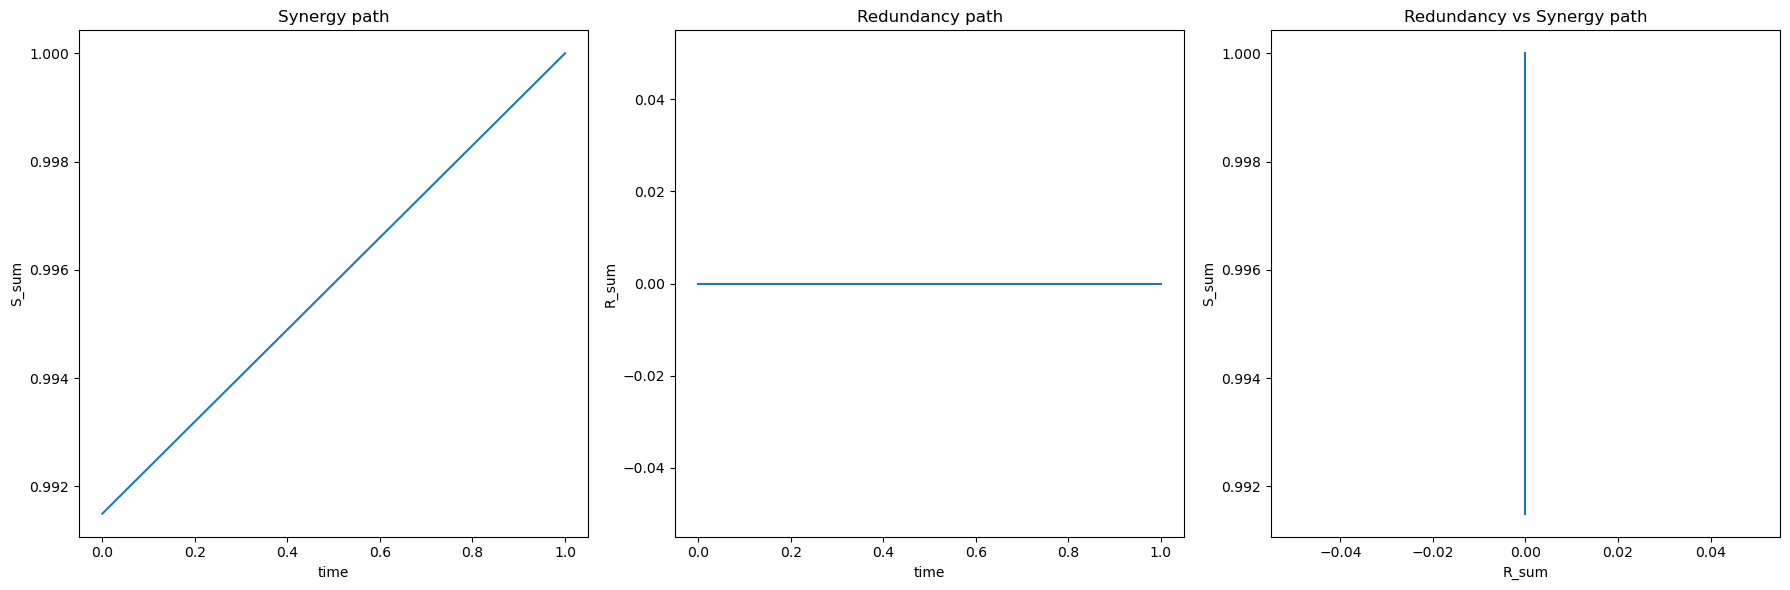

In [70]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.plot(df.index, df['S_sum'])
plt.xlabel('time')
plt.ylabel('S_sum')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.plot(df.index, df['R_sum'])
plt.xlabel('time')
plt.ylabel('R_sum')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.plot(df['R_sum'], df['S_sum'])
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.tight_layout()
plt.show()

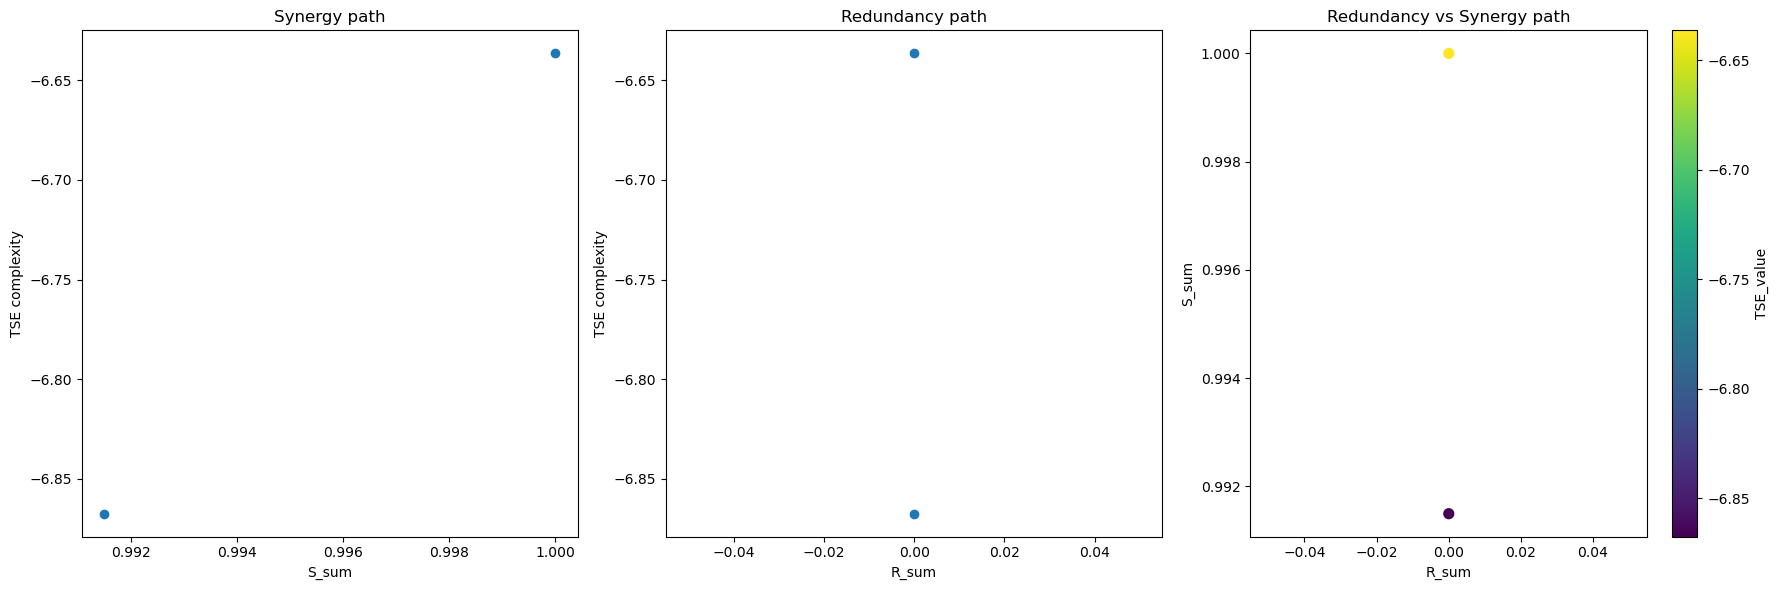

In [71]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.scatter(df['S_sum'], df['TSE_value'])
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'])
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.tight_layout()
plt.show()

ValueError: data type <class 'numpy.object_'> not inexact

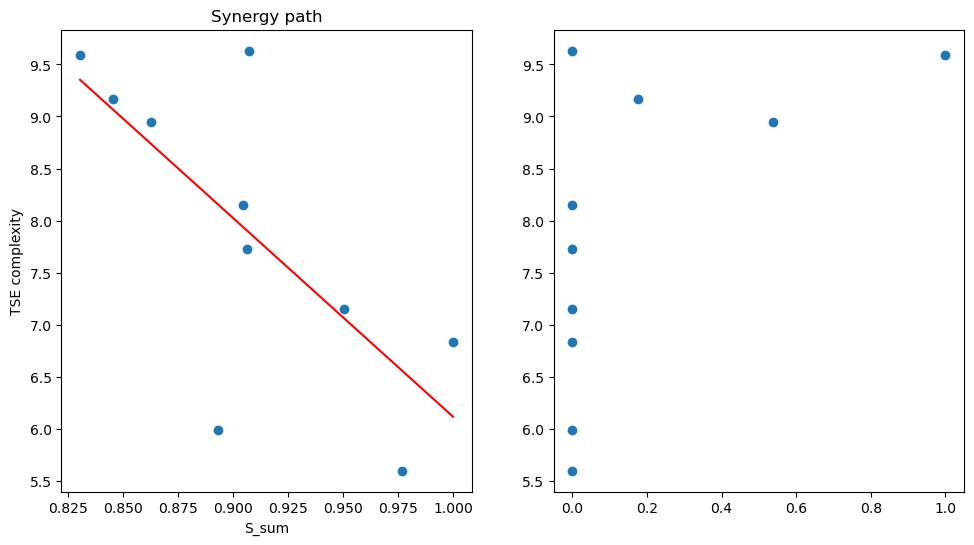

In [52]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.scatter(df['S_sum'], df['TSE_value'])

# Fit a linear regression line
slope, intercept = np.polyfit(df['S_sum'], df['TSE_value'], 1)  # 1 indicates linear fit
line_x = np.linspace(min(df['S_sum']), max(df['S_sum']), 100)  # Create x values for the line
line_y = slope * line_x + intercept  # Calculate y values based on the linear equation
plt.plot(line_x, line_y, color='red')

plt.xlabel('S_sum')
plt.ylabel('TSE complexity')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'])

# Fit a linear regression line
slope, intercept = np.polyfit(df['R_sum'], df['TSE_value'], 1)  # 1 indicates linear fit
line_x = np.linspace(min(df['R_sum']), max(df['R_sum']), 100)  # Create x values for the line
line_y = slope * line_x + intercept  # Calculate y values based on the linear equation
plt.plot(line_x, line_y, color='red')

plt.xlabel('R_sum')
plt.ylabel('TSE complexity')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.tight_layout()
plt.show()